In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tools

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def varBeta(regr, method, lmbd = 0):
    if method == 'ols':
        Bvar = np.sqrt(np.diag(regr.betaVar))
        return Bvar, regr.sigma_y
    if method == 'ridge':
        sigma = regr.sigma_y
        x = regr.symX
        W = np.linalg.inv(x+lmbd*np.eye(x.shape[0]))@x
        Bvar = np.sqrt(np.diag(sigma*W@np.linalg.inv(x)@W.T))
        
        return Bvar, sigma
    else:
        raise ValueError('method needs to be either "ols" or "ridge"')
    

In [4]:
def printvar(regr,Bvar,deg=5):
    mse = regr.squared_error()
    r2 = regr.r2score()
    print('MSE: ', mse)
    print('R2: ', r2)
    print('Conf. int.: ')
    for i in range(len(Bvar)):
        print('B{:}: {:f} {} {:f}'.format(i,regr.beta[i],u'\xb1',Bvar[i]))
        
    df = tools.get_exp_coeffs(beta=regr.beta,deg=deg, print_beta = False)
    plt.imshow(df)
    plt.colorbar()
    plt.xlabel('x order')
    plt.ylabel('y order')
    
    
    return mse,r2

def printvar_lasso(mse,r2,Bvar,reg, deg = 5):
    betas = np.zeros((len(Bvar),))
    print('MSE: ', mse)
    print('R2: ', r2)
    print('Conf. int.: ')
    for i in range(len(Bvar)):
        beta = reg.coef_[i]
        betas[i] = beta
        print('B{:}: {:f} {} {:f}'.format(i,beta,u'\xb1',Bvar[i]))
        
    df = tools.get_exp_coeffs(beta=betas,deg=deg, print_beta = False)
    plt.imshow(df)
    plt.colorbar()
    plt.xlabel('x order')
    plt.ylabel('y order')

## Ordinary linear regression
Make data

In [33]:
deg = 5
N = 2000
lambd = 0.01
noise = 0.1
x,y,z,noise = tools.generate_data(N=N, noise=noise)

X = tools.get_X_poly2D(x,y,deg=deg)

Do regression and print MSE, R2 and beta with conf.int.

In [44]:
# X = tools.get_X_poly2D(x,y,deg=deg)

def olsBeta(X,z, errors = False):
    regr = tools.Regression(X,z,lmbd = 0)

    zpred = regr.yhat
    Bvar,sigma = varBeta(regr,method='ols')
    
    if errors == True:
        mse,r2 = printvar(regr,Bvar)
        
    return regr.beta,Bvar,sigma

### - Mean squared error and R2-score
MSE and R2 of ordinary linear regression, with and without k-fold and bootstrap

In [40]:
import tools

## Without resampling
regr = tools.Regression(X,z)
    
zpred = regr.yhat
mse = regr.squared_error()
r2 = regr.r2score()

print('------- Without resampling -------')
print('MSE: ', mse)
print('R2: ', r2)

## With k-fold
out = tools.k_fold_val(x,y,z, method = 'ols')

k_R2_in = out[0]
k_MSE_in = out[1]
k_R2_out = out[2]
k_MSE_out = out[3]

print('------- With k-fold validation -------')
print('MSE (in): ', k_MSE_in)
print('R2 (in): ', k_R2_in)
print('MSE (out): ', k_MSE_out)
print('R2 (out): ', k_R2_out)

## With bootstrap
b_MSE_out, b_R2_out = tools.bootstrap(x,y,z, method = 'ols', r2_score=True, smplsize=1000)

print('------- With bootstrap -------')
print('MSE (out): ', np.average(b_MSE_out))
print('R2 (out): ', np.average(b_R2_out))

------- Without resampling -------
MSE:  0.011859337875389155
R2:  0.872619942979
------- With k-fold validation -------
MSE (in):  0.011775465019837016
R2 (in):  0.8732387229717149
MSE (out):  0.012121818266651823
R2 (out):  0.8695044269047545
------- With bootstrap -------
MSE (out):  0.012381240787699796
R2 (out):  0.8498504886868116


In [7]:
## VAR PLoT
# plt.figure(figsize=(10,6))
# plt.subplot(2,2,1)
# plt.imshow(Bvar)
# plt.subplot(1,2,2)
# plt.errorbar(np.arange(len(Bvar)), regr.beta/regr.beta, yerr = np.sqrt(np.diag(Bvar)), fmt=".")
# plt.tight_layout()

In [9]:
# df = tools.get_exp_coeffs(Bvar)
# df.columns = ['x^{}'.format(i) for i in df.columns]
# df.index = ['y^{}'.format(i) for i in df.index]
# print(df.to_latex(na_rep='', escape = False,  column_format='lllllll'))

# Ridge regression

In [43]:
# X = tools.get_X_poly2D(x,y,deg=deg)
def ridgeBeta(X,z,lambd, errors = False):
    regr = tools.Regression(X,z,lmbd = lambd)
    
    zpred = regr.yhat
    Bvar,sigma = varBeta(regr,method = 'ridge', lmbd = lambd)

    if errors == True:
        mse,r2 = printvar(regr, Bvar)
    
    return regr.beta, Bvar, sigma
    

### - Mean squared error and R2-score
MSE and R2 of ridge regression, with and without k-fold and bootstrap

In [36]:
import tools

## Without resampling
regr = tools.Regression(X,z,lmbd = lambd)
    
zpred = regr.yhat
mse = regr.squared_error()
r2 = regr.r2score()
#Bvar,sigma = varBeta(regr,method = 'ridge', lmbd = lambd)

print('------- Without resampling -------')
print('MSE: ', mse)
print('R2: ', r2)

## With k-fold
out = tools.k_fold_val(x,y,z, lmbd=lambd)

k_R2_in = out[0]
k_MSE_in = out[1]
k_R2_out = out[2]
k_MSE_out = out[3]

print('------- With k-fold validation -------')
print('MSE (in): ', k_MSE_in)
print('R2 (in): ', k_R2_in)
print('MSE (out): ', k_MSE_out)
print('R2 (out): ', k_R2_out)

## With bootstrap
b_MSE_out, b_R2_out = tools.bootstrap(x,y,z, lmbd=lambd, method = 'ridge', r2_score=True, smplsize=500)

print('------- With bootstrap -------')
print('MSE (out): ', np.average(b_MSE_out))
print('R2 (out): ', np.average(b_R2_out))

------- Without resampling -------
MSE:  0.01394262030151856
R2:  0.850243598108861
------- With k-fold validation -------
MSE (in):  0.014510497188961986
R2 (in):  0.8437597280588398
MSE (out):  0.014779715554599695
R2 (out):  0.8407941983826561
------- With bootstrap -------
MSE (out):  0.016079159976349747
R2 (out):  0.7849896754539337


# Lasso regression

In [42]:
from sklearn.linear_model import Lasso

def lassoBeta(X,z,lambd, errors = False):
    reg = Lasso(alpha = lambd)
    reg.fit(X,z)
    zpred = reg.predict(X)

    mse = tools.squared_error(z,zpred)
    r2 = tools.r2score(z,zpred)
    sigma = 1/(N-deg-1) * np.sum((z-zpred)**2)
    Bvar = np.sqrt(np.diag(np.linalg.inv(X.T@X)*sigma))
    if errors == True:
        printvar_lasso(mse,r2,Bvar,reg,deg)
        
    return reg.coef_, Bvar, sigma

### - Mean squared error and R2-score
MSE and R2 of lasso regression, with and without k-fold and bootstrap

In [39]:
from sklearn.linear_model import Lasso

#lambd = 0.005

reg = Lasso(alpha = lambd)
reg.fit(X,z)
zpred = reg.predict(X)

mse = tools.squared_error(z,zpred)
r2 = tools.r2score(z,zpred)

print('------- Without resampling -------')
print('MSE: ', mse)
print('R2: ', r2)

## With k-fold
out = tools.k_fold_val(x,y,z, method='lasso', lmbd=lambd)

k_R2_in = out[0]
k_MSE_in = out[1]
k_R2_out = out[2]
k_MSE_out = out[3]

print('------- With k-fold validation -------')
print('MSE (in): ', k_MSE_in)
print('R2 (in): ', k_R2_in)
print('MSE (out): ', k_MSE_out)
print('R2 (out): ', k_R2_out)

## With bootstrap
b_MSE_out, b_R2_out = tools.bootstrap(x,y,z, lmbd=lambd, method = 'lasso', r2_score=True, smplsize=500)

print('------- With bootstrap -------')
print('MSE (out): ', np.average(b_MSE_out))
print('R2 (out): ', np.average(b_R2_out))

------- Without resampling -------
MSE:  0.032761609923565874
R2:  0.6481105619881298
------- With k-fold validation -------
MSE (in):  0.03611448495674045
R2 (in):  0.6107806807945044
MSE (out):  0.036464109710808434
R2 (out):  0.6075598172345231
------- With bootstrap -------
MSE (out):  0.0366502375278498
R2 (out):  -0.11211789881324254


# Plot beta as a function of lambda
For b_4

/Users/heine2307/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


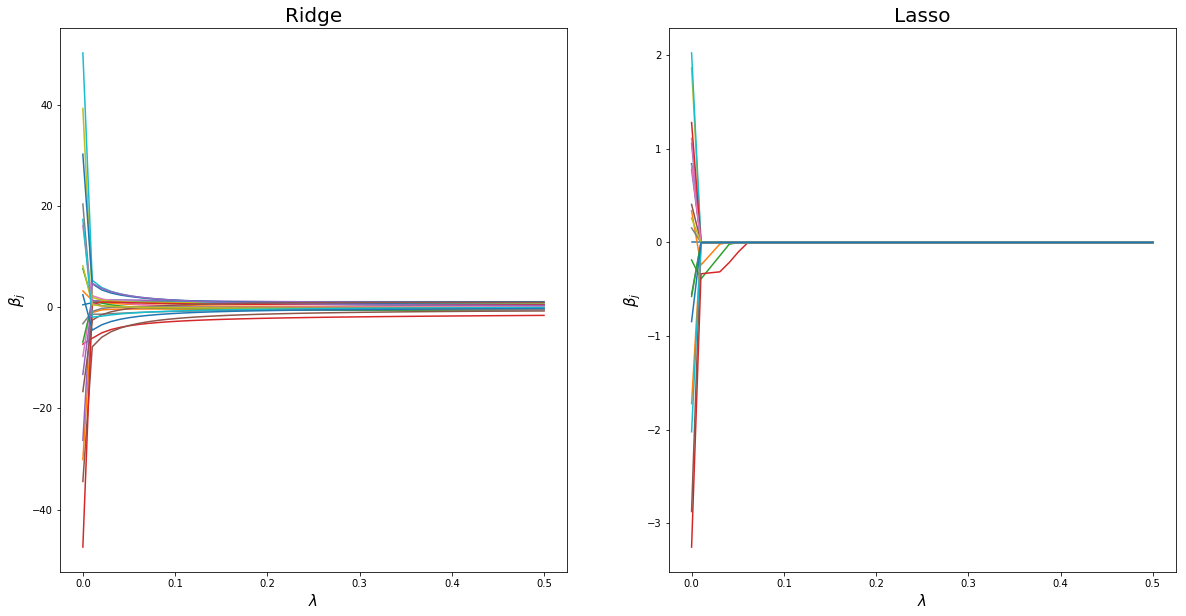

In [51]:
runs = 50
bnum = 10

# OLS beta is not dependent of lambda, so every point is the same
Sb,Sv,Ss = olsBeta(X,z)
Bnum = np.argsort(np.abs(Sb))
bnum = Bnum[0]
#print('Bnum: ',bnum)
Sbeta = np.ones(runs)*Sb[bnum]
Svar = np.ones(runs)*Sv[bnum]
Ssig = np.ones(runs)*Ss

Rbeta = np.zeros(runs)
Rvar = np.zeros(runs)
Rsig = np.zeros(runs)

Rlist = np.zeros((runs,X.shape[1]))

Lbeta = np.zeros(runs)
Lvar = np.zeros(runs)
Lsig = np.zeros(runs)

Llist = np.zeros((runs,X.shape[1]))

#x = 100*np.log10(np.arange(runs))
# x = np.logspace(-3, 2, runs)
x = np.linspace(0, 0.5, runs)

for i, lambd in enumerate(x):
    Rb,Rv,Rs = ridgeBeta(X,z,lambd=lambd)
    Rbeta[i] = Rb[bnum]
    Rvar[i] = Rv[bnum]
    Rsig[i] = Rs
    Rlist[i][:] = Rb
    
    Lb,Lv,Ls = lassoBeta(X,z,lambd=lambd)
    Lbeta[i] = Lb[bnum]
    Lvar[i] = Lv[bnum]
    Lsig[i] = Ls
    Llist[i][:] = Lb

# #OLS
# plt.plot(x,Sbeta, 'r-')
# plt.fill_between(x,Sbeta+Ssig,Sbeta-Ssig,alpha=0.1,color='r')
# #Ridge
# plt.plot(x,Rbeta, 'b-')
# plt.fill_between(x,Rbeta+Rsig,Rbeta-Rsig,alpha=0.1,color='b')
# #Lasso
# plt.plot(x,Lbeta, 'g-')
# plt.fill_between(x,Lbeta+Lsig,Lbeta-Lsig,alpha=0.1,color='g')

fig = plt.figure(figsize=[20,10])
plt.subplot(121)
for i in range(X.shape[1]):
    plt.plot(x,Rlist.T[i])#,'b-')
    plt.fill_between(x,Rlist.T[i]+Rsig,Rlist.T[i]-Rsig,alpha=0.1)#,color='b')
plt.xlabel(r'$ \lambda $',fontsize=15)
plt.ylabel(r'$ \beta_j $',fontsize=15)
plt.title('Ridge',fontsize=20)
#plt.legend(['B_{}'.format(i) for i in range(X.shape[1])])
plt.subplot(122)
for i in range(X.shape[1]):
    plt.plot(x,Llist.T[i])#,'g-')
    #plt.fill_between(x,Lbeta[i]+Lsig,Lbeta[i]-Lsig,alpha=0.1)#,color='g')
plt.xlabel(r'$ \lambda $',fontsize=15)
plt.ylabel(r'$ \beta_j $',fontsize=15)
plt.title('Lasso',fontsize=20)

#plt.savefig('betacoef.pdf')

plt.show()


